[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/05_the_many_variables_and_the_spurious_waffles.ipynb)

# 5. The Many Variables & The Spurious Waffles

In [1]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import daft
from collections import namedtuple
# from causalgraphicalmodels import CausalGraphicalModel

import random
import jax
import jax.numpy as jnp

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%load_ext autoreload
%autoreload 2
import rethinking

from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
# from rethinking.mcmc import sample_posterior

plt.rcParams['figure.figsize'] = [6, 4]

def a_key():
    # return jax.random.key(random.randint(0, 1000_000))
    return jax.random.PRNGKey(random.randint(0, 1000_000))

In [2]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

## 5.1 Spurious association

##### Code 5.1

The chapter is going to use 2 predictor variables - Marriage Rate & Median Age at Marriage to predict the divorce rate. Here we start with the first predictor variable - Median Age at Marriage

Loading the dataset and standardizing the variables of interest (i.e. median age at marriage and divorce rate)

In [3]:
d = RethinkingDataset.WaffleDivorce.get_dataset()

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())

##### Code 5.2

Here is the description of the linear regression model that use Median Age as the predictor variable.

$D_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_AA_i$   

$\alpha \sim Normal(0,0.2)$       

$\beta_A \sim Normal(0,0.5)$          

$\sigma \sim Exponential(1)$ 


We have standardized both D and A this means that the intercept ($\alpha$) should be close to zero. 

A slope ($\beta_A$) of 1 would then imply that a change in one standard deviation in marriage rate is associated with change of one standard deviation in divorce. 

Below we compute the standard deviation in median age

In [4]:
d.MedianAgeMarriage.std()

1.2436303013880823

This means that when $\beta_A$ is 1 then we expect a change of 1.2 years in median age at marriage is associated with 1 full standard deviation of the divorce rate. 

##### Code 5.3

Define the model and compute the posterior

In [43]:
def model_51(median_age_data):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaA = yield tfd.Normal(loc=0.0, scale=0.5, name="betaA")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaA * median_age_data
        divorce = yield tfd.Normal(loc=mu, scale=sigma, name="divorce")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

jd_51 = model_51(d.A.values)

In [44]:
init_state_51 = jd_51.sample(seed=a_key())
names_51 = init_state_51._fields
init_state_51 = init_state_51[:-1]

StateTuple = namedtuple("StateTuple", names_51)
state_name_51 = names_51[:-1]
state_name_51

('alpha', 'betaA', 'sigma')

In [45]:
def target_log_prob_51(alpha, betaA, sigma):
    sample = {"alpha": alpha, "betaA": betaA, "sigma": sigma, "divorce": d.D.values}
    return jd_51.log_prob(StateTuple(**sample))

In [47]:
num_burnin_steps = 400
num_results = 500
step_size = 0.2

In [46]:
kernel_51 = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_51,
    step_size=step_size,
    num_leapfrog_steps=2)

kernel_51 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel_51, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [48]:
states_51 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_51,
    kernel=kernel_51,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None,
    seed=a_key())

In [11]:
## in case of multiple chains.
# tfp.mcmc.sample_chain output shape: (sample, batch, event)
#  == in terms of arviz, (draws, chains, *shape)
# arvis input shape: (chains, draws, *shape)
# states_51 = [jnp.moveaxis(s, 0, 1) for s in states_51]

In [49]:
states_51_dict = states_51._asdict()
az.summary(states_51_dict, round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.09,-0.15,0.15
betaA,-0.57,0.11,-0.71,-0.38
sigma,0.81,0.08,0.69,0.94


##### Code 5.4

Before we do posterior analysis let's check our priors

In [82]:
# Below we are using the value of A (median age)
A = jnp.array([-2.0, 2.0])
jd_51_prior = model_51(A)
prior_pred_samples = jd_51_prior.sample(20, seed=a_key())

In [84]:
prior_alpha = prior_pred_samples[0]
prior_beta = prior_pred_samples[1]
mu = prior_alpha[:, jnp.newaxis] + prior_beta[:, jnp.newaxis] * A

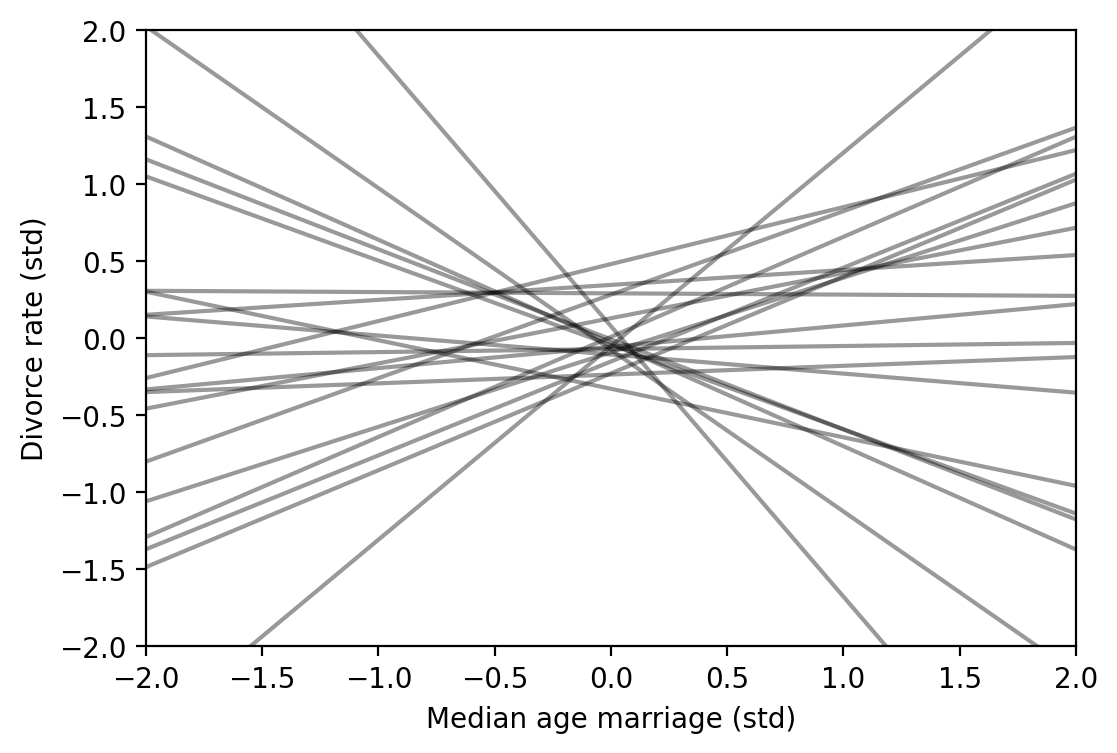

In [86]:
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)");

In [87]:
states_51

StructTuple(
  alpha=Array([-0.067218  ,  0.09717894,  0.09717894, -0.1045128 , -0.1045128 ,
           -0.1045128 , -0.09134048, -0.09134048,  0.12673783,  0.12673783,
            0.02063989,  0.01324556,  0.01324556, -0.0503146 ,  0.11724761,
           -0.00593441,  0.039805  , -0.03469146,  0.03469365,  0.04334452,
            0.04334452,  0.04334452,  0.04334452, -0.01516856, -0.01516856,
            0.0313106 , -0.17396303,  0.08866391, -0.05525352,  0.1509656 ,
            0.1509656 , -0.09463684,  0.03781796, -0.01418424, -0.01418424,
           -0.01418424,  0.01143697,  0.05513887,  0.05513887,  0.06799097,
           -0.03853859,  0.02782688,  0.01265384,  0.01265384,  0.01265384,
            0.03885379,  0.15261705,  0.15261705,  0.15261705, -0.00264779,
            0.16824603, -0.15416586, -0.15416586,  0.04183643, -0.06417295,
            0.12426381, -0.09598634,  0.12234123,  0.12234123,  0.12234123,
            0.12234123, -0.09548005, -0.09548005,  0.0315734 ,  0.03157

##### Code 5.6 

We can now model a simple regression for the Mariage rate as well.

In [90]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [91]:
def model_52(marriage_rate_data):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaM = yield tfd.Normal(loc=0.0, scale=0.5, name="betaM")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaM * marriage_rate_data
        yield tfd.Normal(loc=mu, scale=sigma, name="divorce")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

jd_52 = model_52(d.M.values)

#### Prior

In [ ]:
*_, prior_predictive = jd_52.sample(2500, seed=a_key())

In [ ]:
prior_predictive.shape

(2500, 50)

In [152]:
# arviz expects (chain, draw, *shape)
prior_trace = az.from_dict(
    observed_data={"divorce": d.D.values},
    prior_predictive={"divorce": prior_predictive[jnp.newaxis, ...]},
    # coords={"observation": jnp.arange(50)},
    # dims={"observations": ["observation"]},
)

print(prior_trace.prior_predictive)

<xarray.Dataset> Size: 520kB
Dimensions:        (chain: 1, draw: 2500, divorce_dim_0: 50)
Coordinates:
  * chain          (chain) int64 8B 0
  * draw           (draw) int64 20kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499
  * divorce_dim_0  (divorce_dim_0) int64 400B 0 1 2 3 4 5 ... 44 45 46 47 48 49
Data variables:
    divorce        (chain, draw, divorce_dim_0) float32 500kB 0.0144 ... 0.5083
Attributes:
    created_at:     2024-06-19T13:12:30.175143+00:00
    arviz_version:  0.18.0


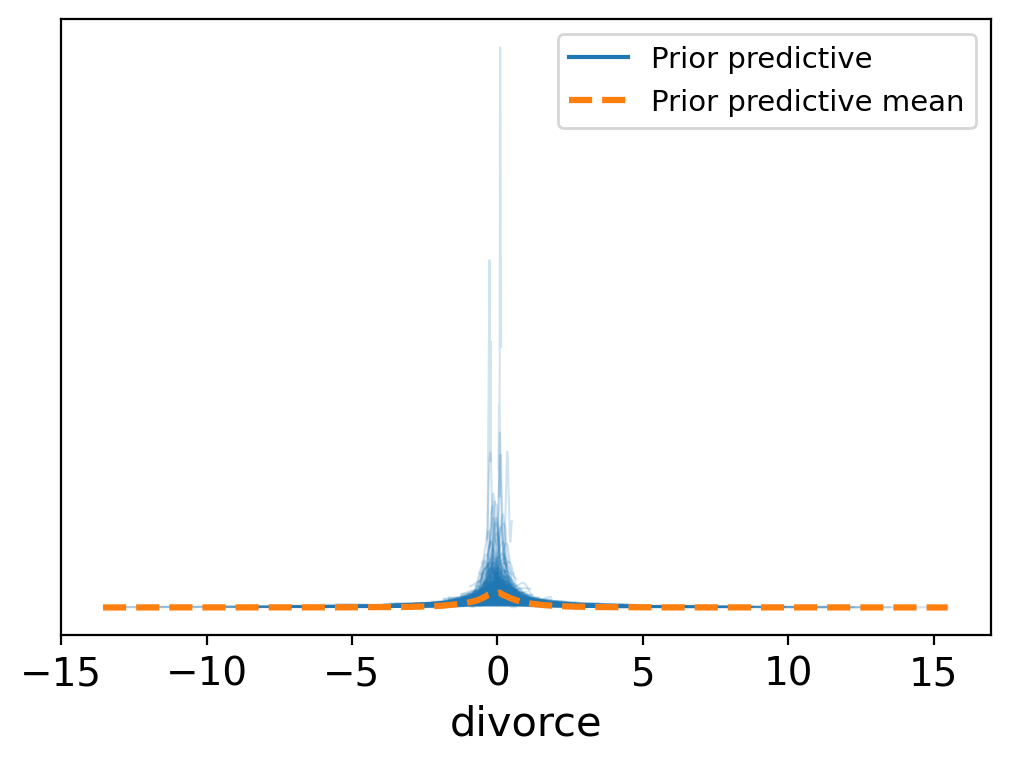

In [ ]:
az.plot_ppc(prior_trace, group="prior", num_pp_samples=500);

#### Posterior

In [141]:
# conditional sample: (betaM, sigma | alpha=0.2)
jd_52.sample(value=[0.2, None, None, None], seed=a_key())

StructTuple(
  alpha=Array(0.2, dtype=float32),
  betaM=Array(1.6419656, dtype=float32),
  sigma=Array(0.39289555, dtype=float32),
  divorce=Array([ 0.1356282 ,  2.8554718 ,  0.56621385,  2.7436047 ,  0.19073851,
            1.9652144 , -1.754112  ,  0.9991354 , -0.57454336, -1.3980854 ,
            1.2982901 ,  2.4740937 ,  2.7311497 , -0.992888  ,  0.13850805,
            1.2599614 ,  0.7107239 ,  1.3097813 ,  0.91296834, -2.0963268 ,
           -0.8217353 , -1.5558923 , -0.91139543, -1.9779117 ,  0.3290522 ,
           -0.70277643, -0.31515723, -0.01897921, -1.7888956 , -2.4288282 ,
            0.41514248, -1.0014454 ,  0.2327303 ,  2.4997826 , -1.5391577 ,
            1.9040382 , -0.15614651, -2.5230289 , -1.9284326 , -0.528813  ,
           -0.35243952,  0.54513353,  0.630811  ,  4.7066536 , -0.71745896,
            0.8442453 ,  1.3869064 ,  1.2987077 , -1.007875  ,  4.599514  ],      dtype=float32)
)

In [135]:
# conditional sample: (betaM, sigma | alpha=0.2)
jd_52.sample(alpha=0.2, seed=a_key())

StructTuple(
  alpha=Array(0.2, dtype=float32),
  betaM=Array(0.41656533, dtype=float32),
  sigma=Array(1.4824997, dtype=float32),
  divorce=Array([-0.3349238 ,  1.6702225 ,  2.8344243 , -1.5363097 ,  2.7437482 ,
           -0.46191847,  0.11664857, -0.87974083,  0.9835101 , -1.6645143 ,
           -0.04748991,  1.9378623 ,  0.1222195 , -3.0466003 , -0.5828819 ,
            1.4618074 ,  1.27688   ,  0.18508871, -0.20733282,  0.8529437 ,
            1.8208349 ,  0.5294172 , -2.2951176 , -0.77963233, -1.4148452 ,
            0.59587103,  0.8594248 ,  0.63986737,  0.7834483 ,  1.3912578 ,
           -2.061859  ,  0.64506465, -1.3021338 , -0.44113016,  1.0976515 ,
            0.13906127, -2.3040504 , -1.6245859 , -0.611477  ,  0.15001655,
            1.1879431 , -1.9790058 , -0.2929294 ,  1.9849842 ,  0.69123155,
            0.66916203,  1.9274731 , -1.111146  ,  2.0919363 ,  0.22172284],      dtype=float32)
)

In [136]:
# conditional distribution: (betaM, sigma | alpha=0.2)
jd_52.experimental_pin(alpha=0.2)

<tfp.distributions.JointDistributionPinned 'PinnedJointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  betaM=[],
  sigma=[],
  divorce=[50]
) dtype=StructTuple(
  betaM=float32,
  sigma=float32,
  divorce=float32
)>

In [140]:
# conditional distribution: (betaM, sigma | alpha=0.2)
tfde = tfp.experimental.distributions
tfde.JointDistributionPinned(jd_52, alpha=0.2)

<tfp.distributions.JointDistributionPinned 'PinnedJointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  betaM=[],
  sigma=[],
  divorce=[50]
) dtype=StructTuple(
  betaM=float32,
  sigma=float32,
  divorce=float32
)>

In [149]:
# conditional distribution i.e., posterior: (alpha, betaM, sigma | divorce)
jd_52_pd = jd_52.experimental_pin(divorce=d.D.values)

In [151]:
jd_52_pd.sample_unpinned(seed=a_key())

StructTuple(
  alpha=Array(0.22570153, dtype=float32),
  betaM=Array(-0.636363, dtype=float32),
  sigma=Array(2.349587, dtype=float32)
)

In [159]:
# from the official document:
# experimental_pin pins some parts, returning an unnormalized distribution object.
# The measure on the space of unpinned values that is represented by this object 
# is not a probability measure, 
# so the values of log_prob will in general not integrate to 1.
def target_log_prob_52(*states):
    return jd_52_pd.unnormalized_log_prob(states)

In [155]:
init_state_52 = jd_52_pd.sample_unpinned(seed=a_key())

In [156]:
num_burnin_steps = 500
num_results = 500
step_size = 0.1

In [160]:
kernel_52 = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_52,
    step_size=step_size,
    num_leapfrog_steps=2)

kernel_52 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel_52, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [162]:
posterior_52 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_52,
    kernel=kernel_52,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None,
    seed=a_key())

In [ ]:
## in case of multiple chains.
# tfp.mcmc.sample_chain output shape: (sample, batch, event)
#  == in terms of arviz, (draws, chains, *shape)
# arvis input shape: (chains, draws, *shape)
# states_51 = [jnp.moveaxis(s, 0, 1) for s in states_51]

In [163]:
posterior_52_dict = posterior_52._asdict()
az.summary(posterior_52_dict, round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.11,-0.15,0.19
betaM,0.34,0.14,0.14,0.56
sigma,0.95,0.10,0.80,1.11


In [164]:
jd_52_pd._flat_resolve_names()

['alpha', 'betaM', 'sigma']

In [169]:
# now, easy to get posterior_predictive
M_seq = jnp.linspace(start=-3.0, stop=3.2, num=30)
jd_52_test = model_52(M_seq)
*_, posterior_predictive = jd_52_test.sample(value=posterior_52, seed=a_key())

In [170]:
posterior_predictive.shape

(500, 30)

In [ ]:
az.plot_pair(d[["M", "D"]].to_dict(orient="list"))
plt.fill_between(M_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.plot(M_seq, mu_mean, "k");


Above plot is showing that the influence of marriage rate is strongly positive with divorce rate

##### Code 5.7


Author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate other. 

How do we understand all this ?

He explains that here we may want to think **causally**. 

Few interesting assumptions (or rather deductions) -

a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D

M -> D

A -> M

and yet another way is to use **DAG** (Directed Acyclic Graphs)


In [ ]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()


Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**.

**MEDIATION** - Let's say that **A** did not directly influenced **D**; rather it did it via **M**. This type of relationship is called *Mediation*


Author raises many interesting questions here. He asks if there is indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a **spurious** coorelation between marriage rate and divorce rate





##### Code 5.8 

Checking conditional indpendencies

In [ ]:
# Note - There is no explicity code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()


In [ ]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)


##### Code 5.9

Checking conditional indpenedencies in the DAG1

In [ ]:
DMA_dag1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)


Executing above cell should not display anything as in the DAG1 (where all nodes are connected to each other) there are no conditional indpedencies.

##### Code 5.10

In [ ]:
def model_5_3(median_age_data, marriage_rate_data):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaA = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaA"), sample_shape=1)
        )
        betaM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaM"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = alpha + betaA * median_age_data + betaM * marriage_rate_data

        divorce = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_3 = model_5_3(tdf.A, tdf.M)

posterior_5_3, trace_5_3 = sample_posterior(
    jdc_5_3, observed_data=(tdf.D,), params=["alpha", "betaA", "betaM", "sigma"]
)


In [ ]:
az.summary(trace_5_3, round_to=2, kind="stats", hdi_prob=0.89)


Let's try to understand the above table generated by arviz.

In the model above, we had include both the predictors i.e. M & A. The weights of M i.e. betaM is approaching zero where as betaA is more or less unchanged.


In [ ]:
az.plot_trace(trace_5_3)
plt.tight_layout();


##### Code 5.11

Here we will take the help of forest plot to compare the posteriors of various models that we have built so far

In [ ]:
coeftab = {"m5.1": trace_5_1, "m5.2": trace_5_2, "m5.3": trace_5_3}

az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    combined=True,
    var_names=["betaA", "betaM"],
    hdi_prob=0.89,
);


Let's learn how to read above plot

m5.1 is our first model where we had used betaA. If we compare it to m5.3 it is more or less at the same place.

whereas,

m5.2 is our second model where we had used betaM. If we compare it to m5.3, it is now closer to zero. 

This is another way to read/plot what we saw in the arviz summary in Code 5.10


From all this, we can say that - once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that state

##### Code 5.12 (TODO)

Possibly revisit this to do what professor has asked to do instead of just translating the code in the cell

In [ ]:
N = 50  # number of simulated States
age = tfd.Normal(loc=0.0, scale=1.0).sample((N,))  # sim A
mar = tfd.Normal(loc=age, scale=1.0).sample()  # sim A -> M
div = tfd.Normal(loc=age, scale=1.0).sample()  # sim A -> D


##### Code 5.13

Following few cells are all about how to plot multivariate posteriors. 

Previously we had only 1 predictor variable and hence a single scatterplot can convey a lot of information. Addition of regression lines and intervals also helped in estimating the size and uncertainity.

However, in the case multivariate regression we would have use other types of plots. 

Author mentions that we need to also know how to select the proper type of plot for a given problem.

He explains 3 types of plots -

* Predictor residual plots

* Posterior prediction plots

* Counterfactual plots



In [ ]:
# we are first redefining our first model. It is exactly the same as m5_1


def model_5_4(median_age_data):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaA = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaA"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = alpha + betaA * median_age_data

        M = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="M"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_4 = model_5_4(tdf.A)

posterior_5_4, trace_5_4 = sample_posterior(
    jdc_5_4, observed_data=(tdf.D,), params=["alpha", "betaA", "sigma"]
)


In [ ]:
az.plot_trace(trace_5_4)
plt.tight_layout();


##### Code 5.14

First is **Predictor residual plot**

In [ ]:
sample_alpha = posterior_5_4["alpha"][0]
sample_betaA = posterior_5_4["betaA"][0]
sample_sigma = posterior_5_4["sigma"][0]

ds, samples = jdc_5_4.sample_distributions(
    value=[sample_alpha, sample_betaA, sample_sigma, None]
)

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_resid = d.M.values - mu_mean


##### Code 5.15

Second is **Posterior prediction plots**

In [ ]:
sample_alpha = posterior_5_3["alpha"][0]
sample_betaA = posterior_5_3["betaA"][0]
sample_betaM = posterior_5_3["betaM"][0]
sample_sigma = posterior_5_3["sigma"][0]

ds, samples = jdc_5_3.sample_distributions(
    value=[sample_alpha, sample_betaA, sample_betaM, sample_sigma, None]
)

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0).numpy()

# get the simulated D
D_sim = samples[-1]
D_PI = tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0)

D_sim.shape


##### Code 5.16

Plot predictions against the observed

In [ ]:
ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce",
)
plt.plot(d.D, mu_mean, "o")
x = np.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf();


The diagonal line shows **perfect predictions**. 

##### Code 5.17

In [ ]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(
            d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
fig


Remember that the above graph is draw using m5_3 that had taken both predictor variables in account.

According to book, above figure shows -
"Model under-predicts for States with very high divorce rate while it over-predicts for states with very low divorce rates."

**I am not able to interpret that :(**


Some states, the ones which are labelled i.e. Idaho (ID), Utah (UT) have lower divorce rates because of religious regions. 


##### Code 5.18 

In [ ]:
N = 100  # number of cases
# x_real as Gaussian with mean 0 and stddev 1
x_real = tfd.Normal(loc=0.0, scale=1.0).sample((N,))
# x_spur as Gaussian with mean=x_real
x_spur = tfd.Normal(loc=x_real, scale=1.0).sample()
# y as Gaussian with mean=x_real
y = tfd.Normal(loc=x_real, scale=1.0).sample()
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})


In [ ]:
d


##### Code 5.19

Third type of plot is called **Counterfactual Plots**

The simplest use of counterfactual plot is to see how the prediction changes as we change **only one** predictor at a time.

In [ ]:
# Reloading the dataset

d = RethinkingDataset.WaffleDivorce.get_dataset()

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

tdf = dataframe_to_tensors("WaffleDivorce", d, ["A", "D", "M"])


In [ ]:
def model_5_3_A(median_age_data, marriage_rate_data):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaA = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaA"), sample_shape=1)
        )
        betaM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaM"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = alpha + betaA * median_age_data + betaM * marriage_rate_data

        divorce = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


def model_5_X_M(median_age_data):
    def _generator():
        alphaM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alphaM"), sample_shape=1)
        )
        betaAM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaAM"), sample_shape=1)
        )
        sigmaM = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigmaM"), sample_shape=1)
        )

        mu_M = alphaM + betaAM * median_age_data

        M = yield tfd.Independent(
            tfd.Normal(loc=mu_M, scale=sigmaM, name="M"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


## First model
jdc_5_3_A = model_5_3_A(tdf.A, tdf.M)
posterior_5_3_A, trace_5_3_A = sample_posterior(
    jdc_5_3_A, observed_data=(tdf.D,), params=["alpha", "betaA", "betaM", "sigma"]
)

## Second model
jdc_5_X_M = model_5_X_M(tdf.A)
posterior_5_X_M, trace_5_X_M = sample_posterior(
    jdc_5_X_M, observed_data=(tdf.M,), params=["alpha", "betaA", "sigma"]
)


In [ ]:
az.plot_trace(trace_5_X_M)
plt.tight_layout();


In [ ]:
az.plot_trace(trace_5_3_A)
plt.tight_layout()


##### Code 5.20

In [ ]:
A_seq = tf.linspace(-2.0, 2.0, num=30)
A_seq = tf.cast(A_seq, dtype=tf.float32)


##### Code 5.21

In [ ]:
sample5X_alpha = posterior_5_X_M["alpha"][0]
sample5X_betaA = posterior_5_X_M["betaA"][0]
sample5X_sigma = posterior_5_X_M["sigma"][0]

# simulate M using A_seq
jdc_5_X_M_test = model_5_X_M(A_seq)

samples = jdc_5_X_M_test.sample(
    value=[sample5X_alpha, sample5X_betaA, sample5X_sigma, None]
)

M_sim = samples[-1]

M_sim.shape


In [ ]:
# time to simulate D using M
sample53A_alpha = posterior_5_3_A["alpha"][0]
sample53A_betaA = posterior_5_3_A["betaA"][0]
sample53A_betaM = posterior_5_3_A["betaM"][0]
sample53A_sigma = posterior_5_3_A["sigma"][0]

jdc_5_3_A_test = model_5_3_A(A_seq, M_sim)

_, _, _, _, D_sim = jdc_5_3_A_test.sample(
    value=[sample53A_alpha, sample53A_betaA, sample53A_betaM, sample53A_sigma, None]
)

D_sim.shape


##### Code 5.22

In [ ]:
# display counterfactual predictions
plt.plot(A_seq, tf.reduce_mean(D_sim, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(
    A_seq, *tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0), color="k", alpha=0.2
)
plt.title("Total counterfactual effect of A on D");


##### Code 5.23  

In [ ]:
M_seq = tf.linspace(-2.0, 2.0, num=30)
M_seq = tf.cast(M_seq, dtype=tf.float32)


def compute_D_from_posterior_using_M(m):
    mu = sample53A_alpha + sample53A_betaM * m
    return tfd.Normal(loc=mu, scale=sample53A_sigma).sample()


D_sim = tf.transpose(
    tf.squeeze(tf.vectorized_map(compute_D_from_posterior_using_M, M_seq))
)
D_sim.shape


In [ ]:
# display counterfactual predictions
plt.plot(M_seq, tf.reduce_mean(D_sim, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated M", ylabel="counterfactual D")
plt.fill_between(
    M_seq, *tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0), color="k", alpha=0.2
)
plt.title("Total counterfactual effect of M on D");


##### Code 5.24, 5.25 and 5.26

Here the author explains how to do above manually in the overthinking box.

Due to the lack of Predictive support in tensorflow prob I had to do it anyways. So refer to above cells.

##### Code 5.27

Previous example used multiple predictors to show case spurious association but sometimes you do need multiple predictor variables as they do have influence on the outcome.

It is possible that one predictor variable is +ively related to outcome whereas the other one is -ively correlated.

We are going to use a new dataset called Milk.

Question that we want to answer is - **To what extent energy content of milk, measured in KCal, is related to the percent of the brain mass that is neocortex**.



In [ ]:
d = RethinkingDataset.Milk.get_dataset()
d.info()
d.head()


* kcal.per.g - Kilocalories of energy per gram of milk
* mass - Average female body mass, in KG
* neocortex.perc - Percent of total brain mass that is neocortex mass

Although not mentioned in the question that was asked above, we are considering the female body mass as well. This is to see the masking that hides the relationships among the variables.


## 5.2 Masked relationship

##### Code 5.28

In [ ]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())

tdf = dataframe_to_tensors("Milk", d, ["K", "N", "M"])


##### Code 5.29

A Simple Bivariate model between KCal and NeoCortex percent

In [ ]:
# N => Standardized Neocortex percent


def model_5_5(neocortex_percent_std):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=1.0, name="alpha"), sample_shape=1)
        )
        betaN = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=1.0, name="betaN"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = alpha + betaN * neocortex_percent_std

        K = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_5 = model_5_5(tdf.N)

samples = jdc_5_5.sample()

samples


If you see above displayed samples, you would see lot of NaN. Now tensorflow prob does not complain and/or throw
an exception here but it is going to cause lot of pain.

In other words, we must not have this situation i.e. presence of NaN

##### Code 5.30

In [ ]:
d["neocortex.perc"]


We have lot of data missing in the neorcortex.perc colums

##### Code 5.31

Drop all the cases with missing values. This is known as **COMPLETE CASE ANANLYSIS**

In [ ]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

# we now have only 17 rows
dcc.describe()


In [ ]:
tdcc = dataframe_to_tensors("Milk", dcc, ["K", "N", "M"])


##### Code 5.32

In [ ]:
jdc_5_5_draft = model_5_5(tdcc.N)

samples = jdc_5_5_draft.sample()

samples


You should not see an NaN in the samples

##### Code 5.33

Investigate if we have proper priors by plotting 50 prior regression lines

In [ ]:
xseq = tf.constant([-2.0, 2.0], dtype=tf.float32)

sample_alpha, sample_betaN, sample_sigma, _ = model_5_5(xseq).sample(1000)

# we simply compute for the two possible values
mu_pred_0 = sample_alpha + sample_betaN * -2.0
mu_pred_1 = sample_alpha + sample_betaN * 2.0

mu_pred = tf.concat([mu_pred_0, mu_pred_1], axis=1)

plt.subplot(xlim=xseq.numpy(), ylim=xseq.numpy())
for i in range(50):
    plt.plot(xseq, mu_pred[i], "k", alpha=0.3)


Above does not look good. We should have better priors for $\alpha$ so that it sticks closer to zero

##### Code 5.34

In [ ]:
def model_5_5(neocortex_percent_std):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaN = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaN"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = alpha + betaN * neocortex_percent_std

        K = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_5 = model_5_5(tdcc.N)

posterior_5_5, trace_5_5 = sample_posterior(
    jdc_5_5, observed_data=(tdcc.K,), params=["alpha", "betaN", "sigma"]
)


##### Code 5.35

In [ ]:
az.summary(trace_5_5, round_to=2, kind="stats", hdi_prob=0.89)


##### Code 5.36

In [ ]:
xseq = tf.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha = posterior_5_5["alpha"][0]
sample_betaN = posterior_5_5["betaN"][0]
sample_sigma = posterior_5_5["sigma"][0]

jdc_5_5_test = model_5_5(xseq)

ds, samples = jdc_5_5_test.sample_distributions(
    value=[sample_alpha, sample_betaN, sample_sigma, None]
)

mu_pred = ds[-1].distribution.loc

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);


Above plot displays weak association when using simple bivariate regression

##### Code 5.37

We now consider another predictor variable; the adult female body mass

In [ ]:
def model_5_6(female_body_mass):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaM"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = alpha + betaM * female_body_mass

        K = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_6 = model_5_6(tdcc.M)

posterior_5_6, trace_5_6 = sample_posterior(
    jdc_5_6, observed_data=(tdcc.K,), params=["alpha", "betaM", "sigma"]
)

az.summary(trace_5_6, round_to=2, kind="stats", hdi_prob=0.89)


Log-mass is negatively correlated with KCal. The influence is stronger than that of neocortex percent but it is in the opposite direction.

##### Code 5.38

Now let's see what happens when we add both the predictor variables to the model

In [ ]:
def model_5_7(neocortex_percent_std, female_body_mass):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaN = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaN"), sample_shape=1)
        )
        betaM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaM"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = alpha + betaN * neocortex_percent_std + betaM * female_body_mass

        K = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_7 = model_5_7(tdcc.N, tdcc.M)

posterior_5_7, trace_5_7 = sample_posterior(
    jdc_5_7, observed_data=(tdcc.K,), params=["alpha", "betaN", "betaM", "sigma"]
)

az.summary(trace_5_7, round_to=2, kind="stats", hdi_prob=0.89)


By including both predictor variables in the regression, the posterior assocition of both with the outcome has increased.

##### Code 5.39

In [ ]:
coeftab = {"m5.5": trace_5_5, "m5.6": trace_5_6, "m5.7": trace_5_7}

az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    combined=True,
    var_names=["betaM", "betaN"],
    hdi_prob=0.89,
);


##### Code 5.40

Counterfactual plot when setting N to zero and using M as the predictor variable 

In [ ]:
xseq = tf.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha = posterior_5_7["alpha"][0]
sample_betaN = posterior_5_7["betaN"][0]
sample_betaM = posterior_5_7["betaN"][0]
sample_sigma = posterior_5_7["sigma"][0]

mu_pred = tf.transpose(
    tf.squeeze(tf.vectorized_map(lambda x: sample_alpha + sample_betaN * x, xseq))
)

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);


##### Code 5.41

In [ ]:
# M -> K <- N
# M -> N
n = 100
M = tfd.Normal(loc=0.0, scale=1.0).sample((n,))
N = tfd.Normal(loc=M, scale=1.0).sample()
K = tfd.Normal(loc=N - M, scale=1.0).sample()

d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

d_sim


##### Code 5.42

In [ ]:
# M -> K <- N
# N -> M
n = 100
N = tfd.Normal(loc=0.0, scale=1.0).sample((n,))
M = tfd.Normal(loc=N, scale=1.0).sample()
K = tfd.Normal(loc=N - M, scale=1.0).sample()

d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = tfd.Normal(loc=0.0, scale=1.0).sample((n,))
M = tfd.Normal(loc=M, scale=1.0).sample()
K = tfd.Normal(loc=N - M, scale=1.0).sample()

d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})


##### Code 5.43 

The book uses `dagitty` an R package that can draw the DAG as well generate the equivalentDAGs given a DAG as input

At this point I do not have the corresponding function in python so I am manually specifying the equivalent DAGs (after seeing the result in RStudio as the book does not display the equivalentDAGs either)

In [ ]:
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
node_names = ["M", "K", "N"]

equivalent_dags = [
    [("M", "K"), ("N", "K"), ("M", "N")],
    [("M", "K"), ("K", "N"), ("M", "N")],
    [("M", "K"), ("N", "K"), ("N", "M")],
    [("K", "M"), ("K", "N"), ("M", "N")],
    [("K", "M"), ("N", "K"), ("N", "M")],
    [("K", "M"), ("K", "N"), ("N", "M")],
]

for e in equivalent_dags:
    dag = CausalGraphicalModel(nodes=node_names, edges=e)
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)

    pgm.render()
    plt.gca().invert_yaxis()


##### Code 5.44

This section discusses Categorical Variables i.e. Discrete & Unordered variables.

We will again use HOWELL dataset here. In previous chapter, we had taken into consider *sex* variable and here we will model it as a categorical variable.

To start with let's load the dataset

In [ ]:
d = RethinkingDataset.Howell1.get_dataset()
d.info()
d.head()


## 5.3 Categorical variables

##### Code 5.45


Here we are considering following model

$h_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_mm_i$   

$\alpha \sim Normal(178,20)$       

$\beta_m \sim Normal(0,10)$          

$\sigma \sim Exponential(1)$ 


*m* here is a categorical value and is 1 when we are dealing with males. This means that $\alpha$ is used
to predict both female and male heights.

But if we have a male then the height gets an extra $\beta_m$. This also means that $\alpha$ does not represent the average of all samples but rather the average of female height.


In [ ]:
mu_female = tfd.Normal(loc=178.0, scale=20.0).sample((int(1e4),))

diff = tfd.Normal(loc=0.0, scale=10.0).sample((int(1e4),))

mu_male = tfd.Normal(loc=178.0, scale=20.0).sample((int(1e4),)) + diff

sample_dict = {"mu_female": mu_female.numpy(), "mu_male": mu_male.numpy()}

az.summary(az.from_dict(sample_dict), round_to=2, kind="stats", hdi_prob=0.89)


The prior for male is wider (see std column). This is because it uses both the parameters.

Author explains that this makes assigning sensible priors harder. As show above, one of the category would have more uncertainity in the prediction as two priors are involved.



##### Code 5.46

Another approach is to use **INDEX VARIABLE**

In [ ]:
d["sex"] = np.where(d.male.values == 1, 1, 0)
d.sex


##### Code 5.47

In [ ]:
tdf = dataframe_to_tensors("Howell1", d, {"height": tf.float32, "sex": tf.int32})


def model_5_8(sex):
    def _generator():
        alpha = yield Root(
            tfd.Sample(
                tfd.Normal(loc=178.0, scale=20.0, name="alpha"), sample_shape=(2,)
            )
        )
        sigma = yield Root(
            tfd.Sample(tfd.Uniform(low=0.0, high=50.0, name="sigma"), sample_shape=1)
        )

        # took long time to figure this out
        mu = tf.transpose(tf.gather(tf.transpose(alpha), sex))

        height = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="height"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_8 = model_5_8(tdf.sex)

posterior_5_8, trace_5_8 = sample_posterior(
    jdc_5_8, observed_data=(tdf.height,), params=["alpha", "sigma"]
)

# now here is the special thing we have to do here
# alpha is actually a vector so for az_trace to display
# it properly I would have to extract it properly
female_alpha, male_alpha = tf.split(posterior_5_8["alpha"][0], 2, axis=1)

# reformatted
posterior_5_8_new = {
    "female_alpha": female_alpha.numpy(),
    "male_alpha": male_alpha.numpy(),
    "sigma": posterior_5_8["sigma"][0],
}

az.summary(az.from_dict(posterior_5_8_new), round_to=2, kind="stats", hdi_prob=0.89)


##### Code 5.48

What is the expected difference between females and males ?

We can use the samples from the posterior to compute this.

In [ ]:
posterior_5_8_new.update({"diff_fm": female_alpha.numpy() - male_alpha.numpy()})

az.summary(az.from_dict(posterior_5_8_new), round_to=2, kind="stats", hdi_prob=0.89)


Note that the above computation (i.e. diff) appeared in the arviz summary. This kind of calculation is called a **CONTRAST**. 

##### Code 5.49


We explore the mile dataset again. We are now interested in `clade` variable which encodes the broad taxonomic membership of each species


In [ ]:
d = RethinkingDataset.Milk.get_dataset()
d.clade.unique()


##### Code 5.50

In [ ]:
d["clade_id"] = d.clade.astype("category").cat.codes

d["clade_id"]


In [ ]:
d.clade


Based on above it seems that pandas is first sorting the categories by name and then assigning the number. So,

* Ape = 0
* New World Monkey = 1
* Old World Monkey = 2
* Strepsirrhine    = 3


##### Code 5.51

We will now model again using the index variables

In [ ]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())

tdf = dataframe_to_tensors("Milk", d, {"K": tf.float32, "clade_id": tf.int64})

CLADE_ID_LEN = len(set(d.clade_id.values))


def model_5_9(clade_id):
    def _generator():
        alpha = yield Root(
            tfd.Sample(
                tfd.Normal(loc=0.0, scale=0.5, name="alpha"),
                sample_shape=(CLADE_ID_LEN,),
            )
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = tf.transpose(
            tf.gather(tf.transpose(alpha), tf.cast(clade_id, dtype=tf.int64))
        )

        K = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_9 = model_5_9(tdf.clade_id)

posterior_5_9, trace_5_9 = sample_posterior(
    jdc_5_9, observed_data=(tdf.K,), params=["alpha", "sigma"]
)

# now here is the special thing we have to do here
# alpha is actually a vector so for az_trace to display
# it properly I would have to extract it properly
ape_alpha, nwm_alpha, owm_alpha, strep_alpha = tf.split(
    posterior_5_9["alpha"][0], 4, axis=1
)

# reformatted
updated_posterior_5_9 = {
    "ape_alpha": ape_alpha.numpy(),
    "nwm_alpha": nwm_alpha.numpy(),
    "owm_alpha": owm_alpha.numpy(),
    "strep_alpha": strep_alpha.numpy(),
    "sigma": posterior_5_9["sigma"][0],
}

az.summary(az.from_dict(updated_posterior_5_9), round_to=2, kind="stats", hdi_prob=0.89)


In [ ]:
labels = ["a[" + str(i) + "]:" + s for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest({"a": trace_5_9.posterior["alpha"].values[0][None, ...]}, hdi_prob=0.89)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)");


##### Code 5.52

In [ ]:
np.random.seed(63)
d["house"] = np.random.choice(np.repeat(np.arange(4), 8), d.shape[0], False)


In [ ]:
d.house


##### Code 5.53

In [ ]:
tdf = dataframe_to_tensors(
    "Milk", d, {"K": tf.float32, "clade_id": tf.int32, "house": tf.int32}
)

CLADE_ID_LEN = len(set(d.clade_id.values))
HOUSE_ID_LEN = len(set(d.house.values))


def model_5_10(clade_id, house_id):
    def _generator():
        alpha = yield Root(
            tfd.Sample(
                tfd.Normal(loc=0.0, scale=0.5, name="alpha"),
                sample_shape=(CLADE_ID_LEN,),
            )
        )
        house = yield Root(
            tfd.Sample(
                tfd.Normal(loc=0.0, scale=0.5, name="house"),
                sample_shape=(HOUSE_ID_LEN,),
            )
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = tf.transpose(
            tf.gather(tf.transpose(alpha), tf.cast(clade_id, dtype=tf.int64))
        ) + tf.transpose(tf.gather(tf.transpose(house), house_id))

        K = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


jdc_5_10 = model_5_10(tdf.clade_id, tdf.house)

posterior_5_10, trace_5_10 = sample_posterior(
    jdc_5_10, observed_data=(tdf.K,), params=["alpha", "house", "sigma"]
)

# now here is the special thing we have to do here
# alpha is actually a vector so for az_trace to display
# it properly I would have to extract it properly
ape_alpha, nwm_alpha, owm_alpha, strep_alpha = tf.split(
    posterior_5_10["alpha"][0], 4, axis=1
)
house_0, house_1, house_2, house_3 = tf.split(posterior_5_10["house"][0], 4, axis=1)

# reformatted
updated_posterior_5_10 = {
    "ape_alpha": ape_alpha.numpy(),
    "nwm_alpha": nwm_alpha.numpy(),
    "owm_alpha": owm_alpha.numpy(),
    "strep_alpha": strep_alpha.numpy(),
    "house_0": house_0.numpy(),
    "house_1": house_1.numpy(),
    "house_2": house_2.numpy(),
    "house_3": house_3.numpy(),
    "sigma": posterior_5_10["sigma"][0],
}

az.summary(
    az.from_dict(updated_posterior_5_10), round_to=2, kind="stats", hdi_prob=0.89
)
